# **Prática Yelp**
## Tópicos Especiais de Sistemas de Informação - Profª Leila Weitzel
### Aluno: Rafael Medeiros Guimarães da Silva

In [1]:
# Carregando as bibliotecas

import pandas as pd
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
import matplotlib.pyplot as plt

2024-10-23 23:26:19.113532: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-23 23:26:19.202398: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-23 23:26:19.321253: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-23 23:26:19.456234: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-23 23:26:19.498854: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-23 23:26:19.672520: I tensorflow/core/platform/cpu_feature_gu

In [2]:
# Carregando o dataset

df = pd.read_csv("/home/rafaelmgsilva/mesc/deeplearning/deeplearning_mesc/yelp/sampled_datasetYelp.csv")

#### Ajuste das orientações da prática
Antes de qualquer análise, vamos retirar as ocorrências com avaliações neutras, conforme as instruções.

In [3]:
# Removendo a classe "neutral"
df = df[df['sentiment_class'].isin(['positive', 'negative'])]

#### Realizando as análises no dataset
Depois da remoção da classe neutra, vamos analisar o dataset

In [4]:
# Visualizando as primeiras linhas
df.head()

,text,sentiment_class
0,I've gone to this location multiple times and ...,positive
1,An amazing Salon with even more amazing staff!...,positive
2,This is our 1st time and I think it is worth 1...,positive
3,Try The Walking Dead arcade game! So much fun!!,negative
4,Delicious!!!,positive


In [5]:
# Informações gerais sobre colunas e tipos de dados
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 38173 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   text             38173 non-null  object
 1   sentiment_class  38173 non-null  object
dtypes: object(2)
memory usage: 894.7+ KB


In [6]:
# Verificando valores únicos na coluna "sentiment_class"
df["sentiment_class"].value_counts()

sentiment_class
positive    32300
negative     5873
Name: count, dtype: int64

In [7]:
# Verificando valores nulos
df.isnull().sum()

text               0
sentiment_class    0
dtype: int64

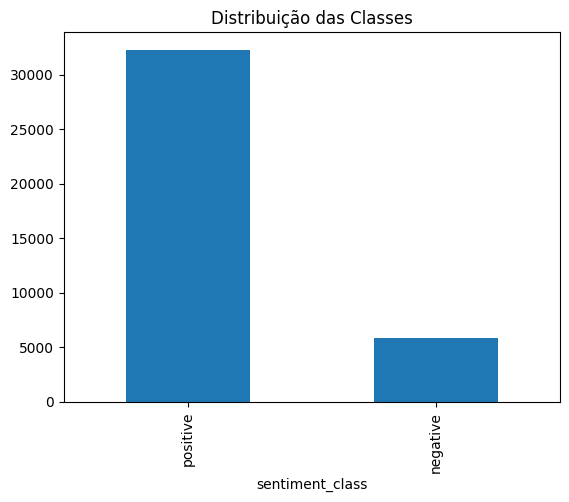

In [8]:
# Verificando o balanceamento de classes
df['sentiment_class'].value_counts().plot(kind='bar')
plt.title('Distribuição das Classes')
plt.show()

#### Balanceando as classes
Agora, conforme as instrução, vamos balancear a classe que se refere à análise de sentimento.

As etapas serão as seguintes:
* Separar dos registros positivos e negativos
* Balancear as classes
* Separar um novo dataset balanceado

A estratégia de balanceamento adotada será balancear pelo valor com menos ocorrência na classe

In [9]:
# Separando os registros positivos e negativos
positive_df = df[df['sentiment_class'] == 'positive']
negative_df = df[df['sentiment_class'] == 'negative']

# Balanceando as classes de acordo com o número de ocorrências com menor registro
min_class_count = min(len(positive_df), len(negative_df))
positive_resampled = resample(positive_df, replace=False, n_samples=min_class_count, random_state=42)
negative_resampled = resample(negative_df, replace=False, n_samples=min_class_count, random_state=42)


In [10]:
# Gerando o novo dataset balanceado
balanced_df = pd.concat([positive_resampled, negative_resampled])

Analisando esse novo dataset

In [11]:
# Informações gerais sobre colunas e tipos de dados
balanced_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11746 entries, 49624 to 7431
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   text             11746 non-null  object
 1   sentiment_class  11746 non-null  object
dtypes: object(2)
memory usage: 275.3+ KB


In [12]:
# Verificando valores únicos na coluna "sentiment_class"
balanced_df["sentiment_class"].value_counts()

sentiment_class
positive    5873
negative    5873
Name: count, dtype: int64

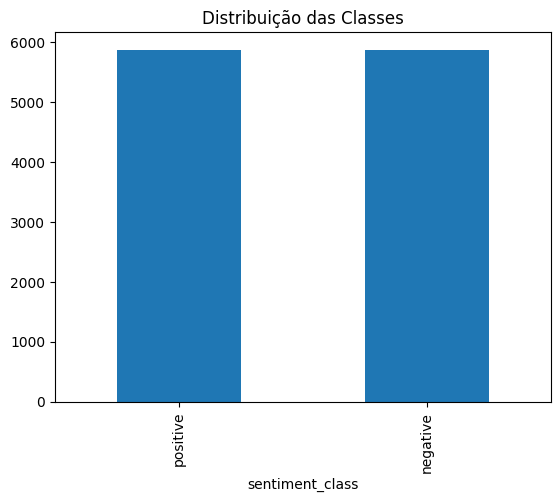

In [13]:
# Verificando o balanceamento de classes
balanced_df['sentiment_class'].value_counts().plot(kind='bar')
plt.title('Distribuição das Classes')
plt.show()

#### Preparação do modelo
Agora vamos começar a preparar o dataset para usar no modelo

In [14]:
# Separando as variáveis features (X) e target(y)
X = balanced_df.drop(columns=['sentiment_class'])
y = balanced_df['sentiment_class']

In [15]:
# Converter colunas categóricas para variáveis dummy
X = pd.get_dummies(X, drop_first=True)

# Converter os valores booleanos para inteiros
X = X.astype(int)

In [16]:
# Convertendo os dados categóricos em variáveis dummy
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [17]:
# Dividindo o conjunto em treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)


In [18]:
# Certificar que X_train e X_test estão em formato NumPy
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()


In [19]:
# Convertendo os dados para float32 para compatibilidade com TensorFlow
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
y_train = y_train.astype('float32')
y_test = y_test.astype('float32')

In [20]:
# Definir tamanho do batch para carregar os dados em partes
batch_size = 8

In [21]:
# Criar tf.data.Dataset para carregamento em lotes
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=512).batch(batch_size)

test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_dataset = test_dataset.batch(batch_size)

2024-10-23 23:27:27.131249: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 434283120 exceeds 10% of free system memory.
2024-10-23 23:27:27.696594: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 108617000 exceeds 10% of free system memory.


#### Construindo um modelo shallow net
Após a preparação dos dados, inicia-se a etapa de construção do modelo shallow net

In [22]:
model = tf.keras.Sequential()

model = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')  # Camada de saída para classificação binária
])

/home/rafaelmgsilva/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [23]:
# Compilando o modelo
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

#### Treinamento do modelo
Agora, de fato, vamos treinar o modelo após a criação e fazer a avaliação

In [24]:
# Treinando o modelo
model.fit(train_dataset, epochs=5, validation_data=test_dataset)

Epoch 1/5


2024-10-23 23:27:41.817034: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 434283120 exceeds 10% of free system memory.


1172/1175 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5092 - loss: 0.6933

2024-10-23 23:27:58.853265: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 108617000 exceeds 10% of free system memory.


1175/1175 ━━━━━━━━━━━━━━━━━━━━ 18s 10ms/step - accuracy: 0.5092 - loss: 0.6933 - val_accuracy: 0.5068 - val_loss: 0.6928
Epoch 2/5
1175/1175 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - accuracy: 0.8325 - loss: 0.4832 - val_accuracy: 0.5149 - val_loss: 0.7468
Epoch 3/5
1175/1175 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - accuracy: 1.0000 - loss: 0.0037 - val_accuracy: 0.5145 - val_loss: 0.8242
Epoch 4/5
1175/1175 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - accuracy: 1.0000 - loss: 3.5108e-04 - val_accuracy: 0.5106 - val_loss: 1.0260
Epoch 5/5
1175/1175 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - accuracy: 1.0000 - loss: 1.6222e-04 - val_accuracy: 0.5115 - val_loss: 1.3326


In [25]:
# Avaliar o modelo
loss, accuracy = model.evaluate(test_dataset)
print(f'Acurácia: {accuracy * 100:.2f}%')


294/294 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5193 - loss: 1.3188
Acurácia: 51.15%
